In [1]:
%load_ext autotime
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')
# sys.path.append('/scratch/pradap/python-work/anhaidgroup/py_entitymatching/')

In [2]:
import py_entitymatching as em
import py_stringsimjoin as ssj
import profiler
import pandas as pd
import qgrid

time: 980 ms


In [3]:
A = em.read_csv_metadata('./ORIG_DBLP_ACM/dblp_sim_title_rem_title_auth_swapped_for_neg_samples_too.csv', key='id')
B = em.read_csv_metadata('./ORIG_DBLP_ACM/acm_sim_title_rem_perturb_year.csv', key='id')

time: 17.7 ms


In [4]:
len(A), len(B)

(1800, 1813)

time: 4.4 ms


In [5]:
A.head(2)

,id,title,authors,venue,year
0,conf/sigmod/Team95a,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,conf/sigmod/BunemanDHS96,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


time: 12.8 ms


In [6]:
B.head(2)

,id,title,authors,venue,year
0,304201,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,672964,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


time: 12.8 ms


In [7]:
A1, B1 = em.down_sample(A, B, 300, 1, show_progress=False)
len(A1), len(B1)

(290, 300)

time: 435 ms


Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM Trans. Database Syst.', 'SIGMOD Conference', 'SIGMOD Record', 'VLDB', 'VLDB J.']

Frequency plot:



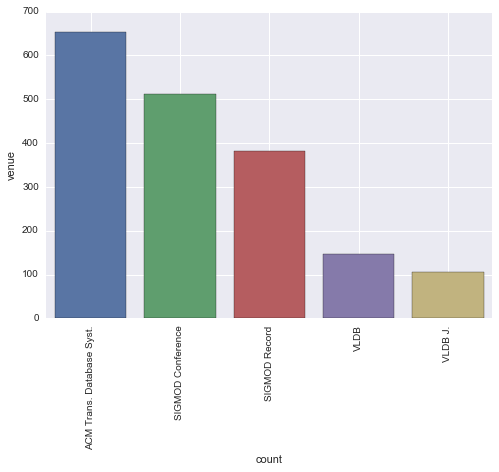

time: 312 ms


In [8]:
# Blocking
profiler.profile_table(A, 'venue')

Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM SIGMOD Record', 'ACM Transactions on Database Systems (TODS)', 'International Conference on Management of Data', 'The VLDB Journal — The International Journal on Very Large Data Bases', 'Very Large Data Bases']

Frequency plot:



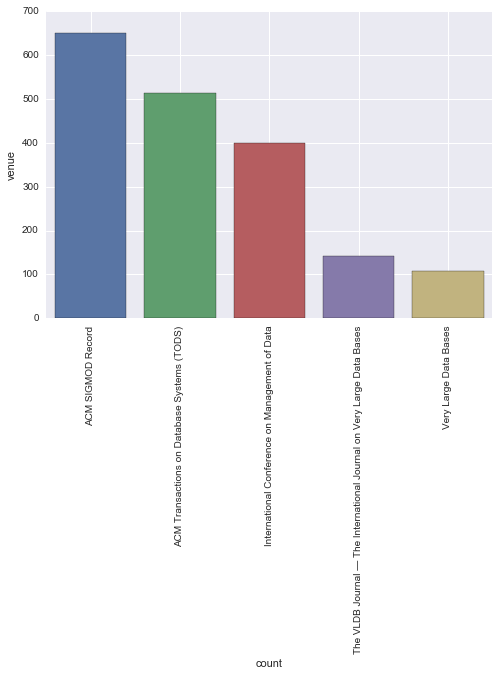

time: 294 ms


In [9]:
profiler.profile_table(B, 'venue')

Number of unique values: 10
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



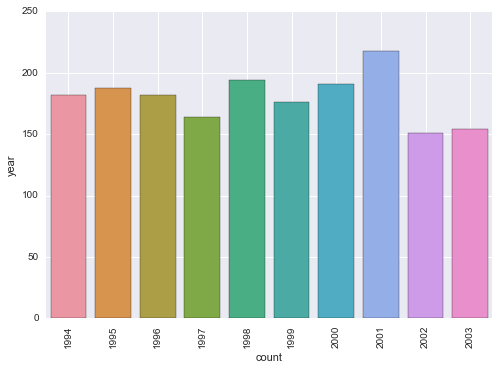

time: 331 ms


In [10]:
profiler.profile_table(A, 'year')

Number of unique values: 10
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



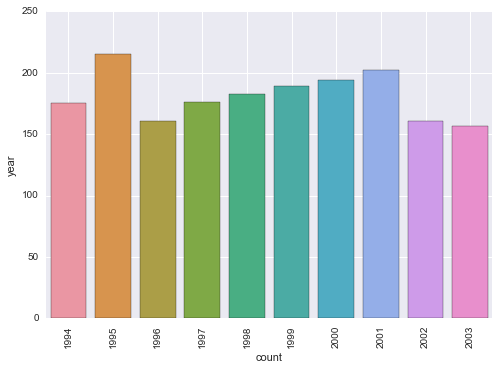

time: 301 ms


In [11]:
profiler.profile_table(B, 'year')

In [12]:
# Plan
### Plan

### A, B -- AttrEquivalnce blocker [year]--------------------------| Candidate set

time: 801 µs


In [13]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )

time: 187 ms


In [14]:
# Debug blocking output

# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B)

time: 1.64 s


In [15]:
# em.view_table(dbg)

time: 688 µs


In [16]:
# Revised blocking plan

# A, B -- AttrEquivalnce blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

time: 737 µs


In [17]:
profiler.profile_table(A, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1798
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 3D Geographic Network Displays, 50,000 Use..."


time: 14.2 ms


In [18]:
profiler.profile_table(B, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1803
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 2Q: A Low Overhead High Performance Buffer..."


time: 20.9 ms


In [19]:
ob = em.OverlapBlocker()
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)

time: 1.22 s


In [20]:
C = em.combine_blocker_outputs_via_union([C1, C2])

time: 1.04 s


In [21]:
# debug blocker
# check again with the updated blocking pipleline
dbg = em.debug_blocker(C, A, B)

time: 2.51 s


In [22]:
# em.view_table(dbg)

time: 587 µs


In [23]:
# Sampling and labeling the candidate set
S = em.sample_table(C, 450)

time: 373 ms


In [24]:
#L = em.label_table(S, 'gold')

time: 597 µs


In [25]:
# Load the pre-labeled data
L = em.read_csv_metadata('./ORIG_DBLP_ACM/labeled_data_dblp_acm_after_monkey_tricks.csv', ltable=A, rtable=B)
# Display the number of rows in the labaled data set
len(L)

450

time: 6.65 ms


In [26]:
L = em.add_output_attributes(L, l_output_attrs=['title', 'authors', 'year'], r_output_attrs=['title', 'authors', 'year'])

time: 15.6 ms


In [27]:
em.view_table(L)

time: 1min 8s


In [28]:
sum(L.label)

150

time: 2.46 ms


In [29]:
L.dtypes

_id                int64
ltable_id         object
rtable_id          int64
label              int64
ltable_title      object
ltable_authors    object
ltable_year        int64
rtable_title      object
rtable_authors    object
rtable_year        int64
dtype: object

time: 5.09 ms


In [30]:
# Split the labeled data into development and evaluation set
development_evaluation = em.split_train_test(L, train_proportion=0.7)
development =  development_evaluation['train']
evaluation = development_evaluation['test']
len(development), len(evaluation)

(315, 135)

time: 15.1 ms


In [31]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree')
svm = em.SVMMatcher(name='SVM')
rf = em.RFMatcher(name='RF')
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg')
ln = em.LinRegMatcher(name='LinReg')

time: 3.91 ms


In [32]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

time: 76.8 ms


In [33]:
# List the names of the features generated
feature_table['feature_name']

0             title_title_jac_qgm_3_qgm_3
1         title_title_cos_dlm_dc0_dlm_dc0
2                         title_title_mel
3                    title_title_lev_dist
4                     title_title_lev_sim
5         authors_authors_jac_qgm_3_qgm_3
6     authors_authors_cos_dlm_dc0_dlm_dc0
7                     authors_authors_mel
8                authors_authors_lev_dist
9                 authors_authors_lev_sim
10                          year_year_exm
11                          year_year_anm
12                     year_year_lev_dist
13                      year_year_lev_sim
Name: feature_name, dtype: object

time: 5 ms


In [34]:
###### Select the year related features
# feature_subset_iter1 = feature_table[6:10]
feature_subset_iter1 = feature_table[0:6]

time: 1.98 ms


In [35]:
feature_subset_iter1

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,title_title_jac_qgm_3_qgm_3,title,title,qgm_3,qgm_3,jaccard,<function title_title_jac_qgm_3_qgm_3 at 0x114f606a8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
1,title_title_cos_dlm_dc0_dlm_dc0,title,title,dlm_dc0,dlm_dc0,cosine,<function title_title_cos_dlm_dc0_dlm_dc0 at 0x115c99048>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
2,title_title_mel,title,title,None,None,monge_elkan,<function title_title_mel at 0x115c99950>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
3,title_title_lev_dist,title,title,None,None,lev_dist,<function title_title_lev_dist at 0x115c99b70>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
4,title_title_lev_sim,title,title,None,None,lev_sim,<function title_title_lev_sim at 0x115c99bf8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
5,authors_authors_jac_qgm_3_qgm_3,authors,authors,qgm_3,qgm_3,jaccard,<function authors_authors_jac_qgm_3_qgm_3 at 0x115c990d0>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True


time: 25.6 ms


In [36]:
# Extract feature vectors
feature_vectors_dev_1 = em.extract_feature_vecs(development, 
                            feature_table=feature_subset_iter1, 
                            attrs_after='label',
                            show_progress=False) 
feature_vectors_dev_2 = em.extract_feature_vecs(development, 
                            feature_table=feature_table, 
                            attrs_after='label',
                            show_progress=False) 

time: 936 ms


In [37]:
# Display first few rows
# feature_vectors_dev.head(3)

time: 852 µs


In [38]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
# feature_vectors_dev.isnull().values.any()

time: 666 µs


In [39]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_1, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1')

time: 164 ms


In [40]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x114ee82e8>,5,0.700000,0.775510,0.780488,0.590909,0.687500,0.706881
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x114ee87b8>,5,0.808511,0.833333,0.777778,0.823529,0.625000,0.773630
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x114ee8a90>,5,0.600000,0.521739,0.571429,0.685714,0.647059,0.605188
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x114ee80f0>,5,0.666667,0.588235,0.733333,0.600000,0.692308,0.656109
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x114ee8080>,5,0.640000,0.620690,0.645161,0.645161,0.742857,0.658774
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x114ee8358>,5,0.480000,0.666667,0.782609,0.700000,0.685714,0.662998


time: 19.3 ms


In [41]:
## Split feature vectors into train and test
train_test = em.split_train_test(feature_vectors_dev_1, train_proportion=0.5)
train = train_test['train']
test = train_test['test']

time: 14.6 ms


In [42]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_2, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1')

time: 197 ms


In [43]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x114ee82e8>,5,0.619048,0.791667,0.900000,0.666667,0.818182,0.759113
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x114ee87b8>,5,0.740741,0.789474,0.791667,0.883721,0.888889,0.818898
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x114ee8a90>,5,0.687500,0.700000,0.756757,0.700000,0.756757,0.720203
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x114ee80f0>,5,0.666667,0.666667,0.608696,0.717949,0.600000,0.651996
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x114ee8080>,5,0.480000,0.666667,0.666667,0.709677,0.733333,0.651269
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x114ee8358>,5,0.606061,0.785714,0.666667,0.571429,0.705882,0.667150


time: 22.2 ms


In [44]:
# # Debug decision tree using GUI
em.vis_debug_dt(dt, train, test, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

time: 25.3 s


In [45]:
# Debug decision tree using GUI
em.vis_debug_rf(rf, train, test, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

time: 2.58 s


In [46]:
em.visualize_tree(dt, (feature_vectors_dev_1.columns), exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'])

Execute the following command in IPython command prompt:

from IPython.display import Image
Image(filename='dt_.png') 
time: 707 ms


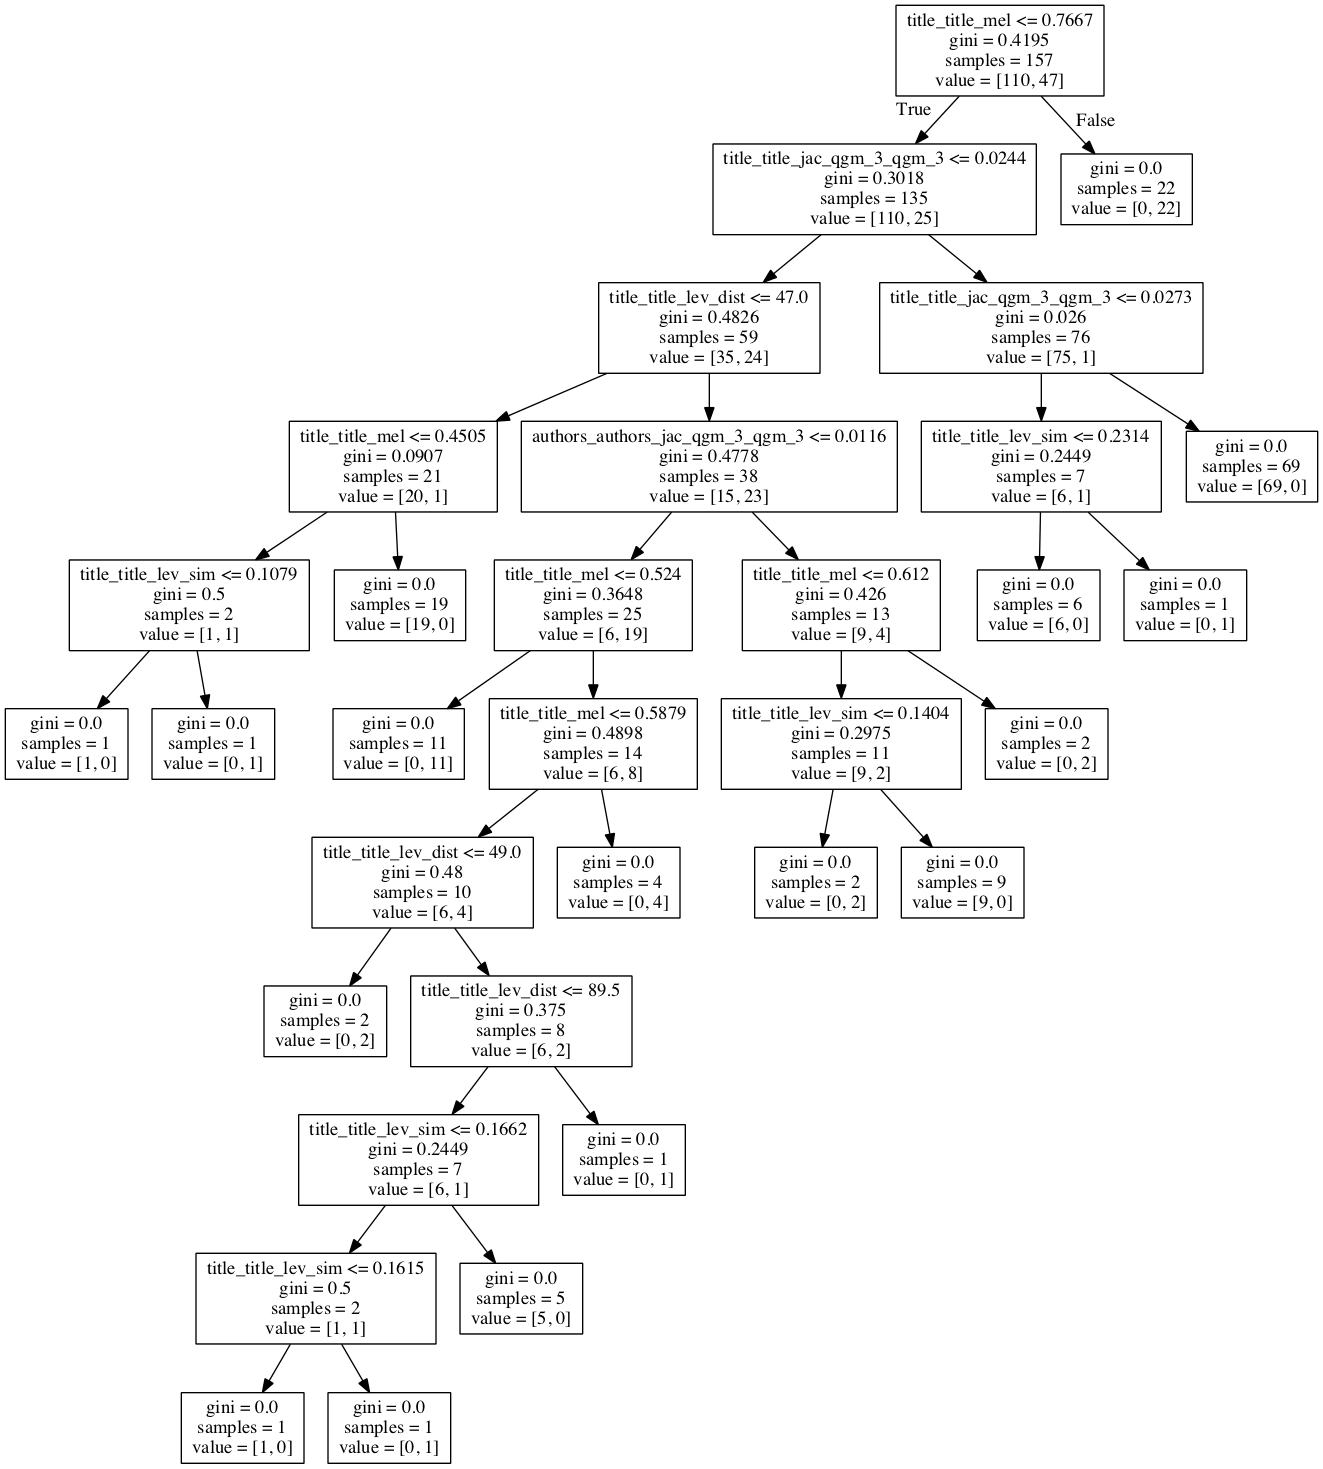

time: 11.8 ms


In [47]:
from IPython.display import Image
Image(filename='dt_.png') 

In [48]:
em._match_t

{'alphabetic': <function py_entitymatching.feature.tokenizers.tok_alphabetic>,
 'alphanumeric': <function py_entitymatching.feature.tokenizers.tok_alphanumeric>,
 'dlm_dc0': <function py_entitymatching.feature.tokenizers._make_tok_delim.<locals>.tok_delim>,
 'qgm_2': <function py_entitymatching.feature.tokenizers._make_tok_qgram.<locals>.tok_qgram>,
 'qgm_3': <function py_entitymatching.feature.tokenizers._make_tok_qgram.<locals>.tok_qgram>,
 'wspace': <function py_entitymatching.feature.tokenizers.tok_wspace>}

time: 2.45 ms


In [49]:
em._match_s

{'abs_norm': <function py_entitymatching.feature.simfunctions.abs_norm>,
 'affine': <function py_entitymatching.feature.simfunctions.affine>,
 'cosine': <function py_entitymatching.feature.simfunctions.cosine>,
 'dice': <function py_entitymatching.feature.simfunctions.dice>,
 'exact_match': <function py_entitymatching.feature.simfunctions.exact_match>,
 'hamming_dist': <function py_entitymatching.feature.simfunctions.hamming_dist>,
 'hamming_sim': <function py_entitymatching.feature.simfunctions.hamming_sim>,
 'jaccard': <function py_entitymatching.feature.simfunctions.jaccard>,
 'jaro': <function py_entitymatching.feature.simfunctions.jaro>,
 'jaro_winkler': <function py_entitymatching.feature.simfunctions.jaro_winkler>,
 'lev_dist': <function py_entitymatching.feature.simfunctions.lev_dist>,
 'lev_sim': <function py_entitymatching.feature.simfunctions.lev_sim>,
 'monge_elkan': <function py_entitymatching.feature.simfunctions.monge_elkan>,
 'needleman_wunsch': <function py_entitymatch

time: 2.72 ms


In [50]:
def title_authors_jac_ws_ws(ltuple, rtuple):
    l_title_author = ' '.join([ltuple['title'], ltuple['authors']])
    r_title_author = ' '.join([rtuple['title'], rtuple['authors']])
    return em.jaccard(em.tok_wspace(l_title_author), em.tok_wspace(r_title_author))

time: 3.22 ms


In [51]:
# em.add_blackbox_feature(new_feature_table, 'fuzz_title_title', fuzz_title_title)
feature_table = em.get_features_for_matching(A, B)
em.add_blackbox_feature(feature_table, 'title_authors_jac_ws_ws', title_authors_jac_ws_ws)

True

time: 167 ms


In [52]:
feature_table

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,title_title_jac_qgm_3_qgm_3,title,title,qgm_3,qgm_3,jaccard,<function title_title_jac_qgm_3_qgm_3 at 0x115b7c268>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
1,title_title_cos_dlm_dc0_dlm_dc0,title,title,dlm_dc0,dlm_dc0,cosine,<function title_title_cos_dlm_dc0_dlm_dc0 at 0x115b7c9d8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
2,title_title_mel,title,title,None,None,monge_elkan,<function title_title_mel at 0x115b7c8c8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
3,title_title_lev_dist,title,title,None,None,lev_dist,<function title_title_lev_dist at 0x115b7cae8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
4,title_title_lev_sim,title,title,None,None,lev_sim,<function title_title_lev_sim at 0x115c99ae8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
5,authors_authors_jac_qgm_3_qgm_3,authors,authors,qgm_3,qgm_3,jaccard,<function authors_authors_jac_qgm_3_qgm_3 at 0x115b267b8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
6,authors_authors_cos_dlm_dc0_dlm_dc0,authors,authors,dlm_dc0,dlm_dc0,cosine,<function authors_authors_cos_dlm_dc0_dlm_dc0 at 0x115b26bf8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
7,authors_authors_mel,authors,authors,None,None,monge_elkan,<function authors_authors_mel at 0x115b26ae8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
8,authors_authors_lev_dist,authors,authors,None,None,lev_dist,<function authors_authors_lev_dist at 0x115b26620>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
9,authors_authors_lev_sim,authors,authors,None,None,lev_sim,<function authors_authors_lev_sim at 0x115b266a8>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True


time: 20 ms


In [53]:
feature_vectors_dev_3 = em.extract_feature_vecs(development, 
                            feature_table=feature_table, 
                            attrs_after='label',
                            show_progress=False) 

time: 667 ms


In [54]:
## Split feature vectors into train and test
train_test = em.split_train_test(feature_vectors_dev_1, train_proportion=0.5)
train = train_test['train']
test = train_test['test']

time: 7.84 ms


In [55]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_3, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1')

time: 211 ms


In [56]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x114ee82e8>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x114ee87b8>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x114ee8a90>,5,0.648649,0.600000,0.780488,0.666667,0.727273,0.684615
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x114ee80f0>,5,1.000000,0.975610,0.941176,0.972973,1.000000,0.977952
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x114ee8080>,5,0.923077,0.888889,0.909091,0.808511,0.965517,0.899017
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x114ee8358>,5,0.972973,0.976744,0.896552,0.909091,0.869565,0.924985


time: 28 ms
